In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#input: data, expected peaks (substrate and metabolite)(dictionary?/two lists?
data = pd.read_csv('../Data/FA_20231113_2H_yeast_Pyruvate-d3_5.csv')

#expected peaks for different substrates
Pyruvate_compound = ['Substrate', 'metabolite1', 'metabolite2']
peaks_pyruvate= [2.468, 1.2261, 1.9775]

spectra_data= data.iloc[:,1:]
chem_shifts = data.iloc[:,0] 

In [6]:
def simple_viz(data):
    import seaborn as sns
    import matplotlib.pyplot as plt

    chem_shifts = data.iloc[:, 0]

    plt.figure(figsize=(10, 6))
    for i in range(1, data.shape[1]):
        sns.lineplot(x=chem_shifts, y=data.iloc[:, i])

    plt.xlabel('Chemical Shifts')
    plt.ylabel('Intensity')
    plt.show()

---
# Peak_fit and peakfit_sum

In [7]:
#define function to check for peaks in sum with high threshold

def peak_fit(intensity, chem_shifts, threshold_percentile):
    """calculates possible peaks as minima of the second derivative and returns list of peaks

    Args:
        spectra_data (_type_): x data of spectra
        chem_shifts (_type_): y data of spectra
        threshold_percentile (int | float): Threshold above which the relevant data lies

    Returns:
        list: peak positions
    """
    threshold = np.percentile(intensity, threshold_percentile)
    first_derivative = np.gradient(intensity, chem_shifts)
    second_derivative = np.gradient(first_derivative, chem_shifts)
    third_derivative = np.gradient(second_derivative, chem_shifts)
    fourth_derivative = np.gradient(third_derivative, chem_shifts)

    sign_change = np.diff(np.sign(third_derivative)) != 0
    peak_mask = (intensity > threshold) & (second_derivative < 0) & (fourth_derivative > 0)
    peak_mask[1:] &= sign_change

    return chem_shifts[peak_mask].tolist()


def peakfit_sum(spectra_data, chem_shifts, threshold):
    """sums up all spectra and returns list of found peaks (needs existing function peak_fit)

    Args:
        filename (str): file with spectra data
        threshold_percentile (int | float): Threshold above which the relevant data lies
    """
    sum_of_spectra = np.sum(spectra_data, axis=1)
    peak_pos = peak_fit(sum_of_spectra, chem_shifts, threshold)

    return peak_pos


In [8]:
#get peaks in sum of sepctra
peak_pos = peakfit_sum(spectra_data, chem_shifts, 85)

---
# normalize_water (added)

In [9]:
def normalize_water(data:pd.DataFrame):
    """adjusts the data to the chem_shift(water) = 4.7, based on the closest peak in summed up spectra
    --> needs existing function 'peakfit_sum', peak_fit

    Args:
        data (pd.DataFrame): spectra data with chem_shift in first column

    Returns:
        data_normalized (pd.DataFrame): dataframe with normalized data
    """

    spectra_data= data.iloc[:,1:]
    chem_shifts = data.iloc[:,0] 

    peak_pos = peakfit_sum(spectra_data, chem_shifts, 85)

    #identify water peak (closest to 4.7
    water = 4.7
    closest_peak = min(peak_pos, key=lambda x: abs(x - water))

    # reposition the whole spectra
    data_normalized = pd.DataFrame(chem_shifts.copy() + ( 4.7 - closest_peak))
    data_normalized = pd.concat([data_normalized, data.iloc[:, 1:]], axis=1)

    # Neubenennung der Spalten, um die Originalstruktur zu erhalten
    data_normalized.columns = data.columns

    return data_normalized


In [10]:
data_normalized = normalize_water(data)

In [11]:
#test
print(peak_pos)
print(peakfit_sum(data_normalized.iloc[:,1:], data_normalized.iloc[:,0], 85))

[1.23428, 1.38903, 1.53972, 1.97548, 2.4316, 4.70407]
[1.2302100000000005, 1.3849600000000004, 1.5356500000000004, 1.9714100000000003, 2.4275300000000004, 4.7]


---
# Identify Peaks based on similarity to expected peaks

<div class="alert alert-block alert-warning">
was wenn bereits gematchter Peak weiter weg von peak als ein nachher gefndener? --> Peak nicht vorhancden aber in anderem zeitlichen Abschnitt

In [12]:
def peak_identify(data_normalized: pd.DataFrame, expected_peaks: list,  compound_names: list, initial_threshold = 85, max_shift = 0.15):
    """searches for peaks and matches them to the closest expected peak respecting the maximal shift. 
    Unidentified peaks are added to other(list). 
    Threshold is lowered until all expected peaks are found or number of other peaks succeeds numer of expected peaks
    
    needs existing function 'peakfit_sum'
    
    Args:
        data_normalized (pd.DataFrame): _description_
        compound_names (list): list with names of expected compunds (optional)
        expected_peaks (list): list with positions of expected peaks
        max_shift: maximum distance to expected peak position for 

    Returns:
        found (list): list with identified peaks most likely the expected ones
        other (list):  list with other found peaks
    """

    spectra_data= data_normalized.iloc[:,1:]
    chem_shifts = data_normalized.iloc[:,0]

    #create enpty lists for found and identified peaks
    found = [None] * len(expected_peaks)
    other = []
    threshold = initial_threshold

    while None in found or len(other) <= len(found):
        
        #search for peaks above given threshold
        detected_peaks = peakfit_sum(spectra_data, chem_shifts, threshold)
        
        for peak in detected_peaks:
            distances = [abs(peak - expected_peak) for expected_peak in expected_peaks]
            min_distance = min(distances)
            index = distances.index(min_distance)
            
            if min_distance <= max_shift:
                if found[index] is None:
                    found[index] = peak
                elif found[index] != peak:
                    other.append(peak)
            elif min_distance > max_shift:
                other.append(peak)
            
        threshold -= 2

        if threshold < 0 or None not in found or len(other) > len(found):
            if None not in found:
                print('allet jefunden')
                break
            else: 
                break

    print("Found Peaks: ", found)
    print("Other Peaks: ", other)

    return found, other

In [13]:
Pyruvate_compound = ['Substrate', 'metabolite1', 'metabolite2']
peaks_pyruvate= [2.468, 1.2261, 1.9775]

peak_identify(data_normalized, peaks_pyruvate, Pyruvate_compound)

allet jefunden
Found Peaks:  [2.4275300000000004, 1.2302100000000005, 1.9714100000000003]
Other Peaks:  [1.3849600000000004, 1.5356500000000004, 4.7]


([2.4275300000000004, 1.2302100000000005, 1.9714100000000003],
 [1.3849600000000004, 1.5356500000000004, 4.7])

---
## Visualization (validation)

In [14]:
def plot(data_normalized, compound_names, expected_peaks = []):
    """runs full peak identification process and creates a visualization
    needs existing function peak_identify and all connected

    Args:
        data_normalized (_type_): _description_
        compound_names (_type_): _description_
        expected_peaks (list, optional): _description_. Defaults to [].
    """

    spectra_data= data_normalized.iloc[:,1:]
    chem_shifts = data_normalized.iloc[:,0]
    # Summiere die Spektren aus
    summed_spectra = spectra_data.sum(axis=1)
    found, other = peak_identify(data_normalized, expected_peaks, compound_names)
    
    # Plotte das aussummierte Spektrum
    plt.plot(chem_shifts, summed_spectra, label='sum of spectra')
    
    # Zeichne die gefundenen Peaks
    for peak in found:
        if peak is not None:
            plt.axvline(x=peak, color='r', linestyle='--')
    for peak in other:
        plt.axvline(x=peak, color='orange', linestyle='--')
    
    plt.xlabel('chem_shift')
    plt.ylabel('intensity')
    plt.title('sum of spectra')
    plt.legend()
    plt.show()
   

allet jefunden
Found Peaks:  [2.4275300000000004, 1.2302100000000005, 1.9714100000000003]
Other Peaks:  [1.3849600000000004, 1.5356500000000004, 4.7]


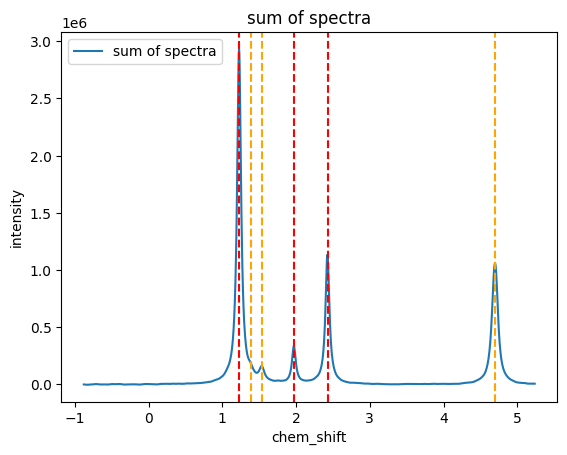

In [15]:
plot(data_normalized, Pyruvate_compound, peaks_pyruvate)

---
---
# Find Peaks separated into three parts

In [16]:
# Spaltenanzahl ohne die chem_shift-Spalte ermitteln
cols_to_divide = len(data.columns) - 1

# Die Anzahl der Spalten für jeden neuen DataFrame berechnen
cols_per_part = cols_to_divide // 3

# DataFrames erstellen
df_part1 = data.iloc[:, :cols_per_part + 1]
df_part2 = data.iloc[:, [0] + list(range(cols_per_part + 1, 2 * cols_per_part + 1))]
df_part3 = data.iloc[:, [0] + list(range(2 * cols_per_part + 1, cols_to_divide + 1))]

---
# combined function 

bullshot, nihct columns dividen sondern lines

In [17]:
def peak_identification_full(data, expected_peaks, shift_tol = 0.01):
    #normalize data
    df = normalize_water(data)


    #separate data into three parts
    cols_to_divide = len(data.columns) - 1
    cols_per_part = cols_to_divide // 3

    df_part1 = data.iloc[:, :cols_per_part + 1]
    df_part2 = data.iloc[:, [0] + list(range(cols_per_part + 1, 2 * cols_per_part + 1))]
    df_part3 = data.iloc[:, [0] + list(range(2 * cols_per_part + 1, cols_to_divide + 1))]


    #find peaks
    found1, other1 = peak_identify(df_part1, expected_peaks)
    found2, other2 = peak_identify(df_part2, expected_peaks)
    found3, other3 = peak_identify(df_part3, expected_peaks)
    
    #combine results,
    #what is maximum shift over time --> 0.01?
    #problem if peaks shift over time and are suddenly more similar to other compund --> fuck

    #chat gpt
    found_lists = [found1, found2, found3]
    other_lists = [other1, other2, other3]

    final_found = []
    final_other= []

    # Zusammenführen und Filtern der "found" Listen
    for i in range(len(expected_peaks)):
        current_peaks = [found[i] for found in found_lists if i < len(found)]

        if current_peaks: #add value thats closest to expected peak to final list
            closest_peak = min(current_peaks, key=lambda x: abs(x - expected_peaks[i]))
            final_found.append(closest_peak)
            
            for peak in current_peaks:
                if abs(peak - closest_peak) >= shift_tol: #<<-- tolerance for peak shift over time
                    final_other.append(peak)

    # Entfernen von Duplikaten und ähnlichen Werten in der "other" Liste
    for other in other_lists:
        for peak in other:
            if not any(abs(peak - o) < shift_tol for o in final_other): 
                final_other.append(peak)



    # Zur Vermeidung von Duplikaten in 'final_other' nach dem Zusammenführen.
    filtered_final_other = []
    for o in final_other:
        if not any(abs(o - ffo) < shift_tol for ffo in filtered_final_other):
            filtered_final_other.append(o)

    final_other = filtered_final_other
    ### chat gpt ende


    peak_pos = final_found + final_other

    return peak_pos
    #return final_found, final_other


<div class="alert alert-box alert-warning">
split into more than 3, at least 20(?) per part

dataframe |timeframe|list of xvalues|

---
---
# full visualization

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

In [ ]:
def peak_fit_viz(data, expected_peaks, compound_names, shift_tol=0.01, viz=True):
    # normalize data
    df = normalize_water(data)

    # Split into section with at least 20 columns each
    cols_to_divide = len(data.columns)
    min_cols_per_section = 20
    num_sections = max(cols_to_divide // min_cols_per_section, 1) if cols_to_divide > min_cols_per_section else 1

    cols_per_section = cols_to_divide // num_sections
    extra_cols = cols_to_divide % num_sections  # Extra columns to distribute

    sections = []
    start_col = 0
    for section in range(num_sections):
        # Include extra column in this section if needed
        extra = 1 if section < extra_cols else 0
        if section == 0:
            sections.append(data.iloc[:, :cols_per_section + extra])
        else:
            end_col = start_col + cols_per_section + extra
            sections.append(data.iloc[:, [0] + list(range(start_col, end_col))])
            start_col = end_col

    found_lists = []
    other_lists = []

    # Process each section for peaks
    for df_section in sections:
        found, other = peak_identify(df_section, expected_peaks, compound_names)
        found_lists.append(found)
        other_lists.append(other)

    # Merge and filter results for found peaks
    final_found = []
    final_other = []

    for i in range(len(expected_peaks)):
        current_peaks = [found[i] for found in found_lists if i < len(found)]
        if current_peaks:
            closest_peak = min(current_peaks, key=lambda x: abs(x - expected_peaks[i]))
            final_found.append(closest_peak)

            for peak in current_peaks:
                if abs(peak - closest_peak) >= shift_tol:  # tolerance for peak shift over time
                    final_other.append(peak)

    # Remove duplicates and similar values in the "other" list
    for other in other_lists:
        for peak in other:
            if not any(abs(peak - o) < shift_tol for o in final_other):
                final_other.append(peak)

    filtered_final_other = []
    for o in final_other:  # Avoid duplicates in 'final_other' after merging
        if not any(abs(o - ffo) < shift_tol for ffo in filtered_final_other):
            filtered_final_other.append(o)
    final_other = filtered_final_other

    #visualize
    if viz == True:
        fig = plt.figure(figsize=(10, 15))
        gs = gridspec.GridSpec(3, 2, figure=fig, width_ratios=[20, 1], height_ratios=[1, 2, 2], hspace=0.05, wspace=0.02)
        
        # Erster Plot: Aufsummierte Spektren für jede Section
        ax_sum = fig.add_subplot(gs[0, 0])
        for i, section in enumerate(sections):
            sum_of_spectra = section.sum(axis=1)  # Hier ändern Sie eventuell die Achse, je nach Datenstruktur
            ax_sum.plot(sum_of_spectra, label=f"Section {i+1}")
        ax_sum.set_ylabel('Sum of Spectra Intensity')
        ax_sum.legend()
        
        # Zweiter Plot: Alle Spektren
        ax_all = fig.add_subplot(gs[1, 0], sharex=ax_sum)
        for section in sections:
            ax_all.plot(section)
        ax_all.set_ylabel('Spectrum Intensity')
        
        # Dritter Plot: Heatmap mit Sectionsmarkierung
        ax_heatmap = fig.add_subplot(gs[2, 0], sharex=ax_sum)
        cax = fig.add_subplot(gs[2, 1])
        combined_data = pd.concat(sections, axis=1)
        
        im = ax_heatmap.imshow(combined_data, aspect='auto', cmap='viridis')
        
        # Markiere Sectionen in der Heatmap
        section_end = np.cumsum([s.shape[1] for s in sections])
        for end in section_end:
            ax_heatmap.axhline(end-0.5, color='white', linestyle='--')  # Zeichnet Linien zwischen den Sections
        
        fig.colorbar(im, cax=cax, orientation='vertical', label='Intensity')
        ax_heatmap.set_ylabel('Sample')
        
        plt.show()

    #     fig = plt.figure(figsize=(10, 15))
    #     gs = gridspec.GridSpec(4, 2, figure=fig, width_ratios=[20, 1], height_ratios=[1, 1, 0.5, 0.5], hspace=0.05, wspace=0.02)
    #     ax_parts = fig.add_subplot(gs[0,0])
    #     ax_sum = fig.add_subplot(gs[1, 0], sharex= ax_parts)
    #     ax_3d = fig.add_subplot(gs[2:4, 0], sharex = ax_sum)
    #     cax = fig.add_subplot(gs[2:4, 1])
        

In [ ]:
cols_to_divide = len(df.columns) - 1  # -1, weil die erste Spalte die chemische Verschiebung ist
num_sections = max(cols_to_divide // min_cols_per_section, 1) if cols_to_divide > min_cols_per_section else 1

cols_per_section = cols_to_divide // num_sections
extra_cols = cols_to_divide % num_sections  # Extra Spalten, die verteilt werden

sections = []
start_col = 1  # Beginne mit der zweiten Spalte, um die erste Spalte zu ignorieren

for section in range(num_sections):
    extra = 1 if section < extra_cols else 0
    end_col = start_col + cols_per_section + extra
    # Ändere df.iloc[:, start_col:end_col] zu df.iloc[:, [0] + list(range(start_col, end_col))],
    # um die erste Spalte in jede Section einzuschließen
    sections.append(df.iloc[:, [0] + list(range(start_col, end_col))])
    start_col = end_col

In [ ]:
def peak_fit_viz(data, expected_peaks, compound_names, shift_tol=0.01, viz=True, min_cols_per_section=20):
    # normalize data
    df = normalize_water(data)
   
    # Split into sections with at least 20 columns each
    cols_to_divide = len(df.columns) - 1 # -1 because the first column is for chemical shift
    num_sections = max(cols_to_divide // min_cols_per_section, 1) if cols_to_divide > min_cols_per_section else 1

    cols_per_section = cols_to_divide // num_sections
    extra_cols = cols_to_divide % num_sections

    sections = []
    Sektionen = []
    found_lists = []
    other_lists = []

    start_col = 1 # Start from the second column, ignoring the chemical shift column

    for section in range(num_sections):
        extra = 1 if section < extra_cols else 0
        end_col = start_col + cols_per_section + extra

        # Keep chemical shift in each section for analysis but don't count it towards the cols_per_section
        sections.append(df.iloc[:, [0] + list(range(start_col, end_col))]) 
        found, other = peak_identify(sections, expected_peaks, compound_names, shift_tol=shift_tol)
        
        # Corresponding section number for each column
        Sektionen.extend([f"Sektion {section + 1}"] * (end_col - start_col))
        
        # Store found and other peaks for the entire section
        found_lists.append(found)
        other_lists.append(other)

        start_col = end_col

    # Prepare the final DataFrame
    # Exclude the first column name (chemical shift) when adding to the final DataFrame
    final_df = pd.DataFrame({
        'Column': df.columns[1:],  # Exclude the chemical shift from the final DataFrame columns
        'Sektion': Sektionen
    })

    # Add Found and Other peaks lists, repeated per section
    # Use the length of sections to determine repeats for each section's peaks
    peaks_data = {'Found Peaks': [], 'Other Peaks': []}
    for i in range(num_sections):
        section_length = len(sections[i].columns) - 1  # -1 to ignore the chemical shift column
        peaks_data['Found Peaks'].extend([found_lists[i]] * section_length)
        peaks_data['Other Peaks'].extend([other_lists[i]] * section_length)

    final_df['Found Peaks'] = peaks_data['Found Peaks']
    final_df['Other Peaks'] = peaks_data['Other Peaks']

    return final_df



In [ ]:
# combined:
def peak_fit_viz(data, expected_peaks, compound_names, shift_tol=0.01, viz=True, min_cols_per_section = 20):

    # normalize data
    df = normalize_water(data)
   
    # Split into section with at least 20 columns each
    cols_to_divide = len(df.columns)-1 #-1 because first column is chemical shift
    num_sections = max(cols_to_divide // min_cols_per_section, 1) if cols_to_divide > min_cols_per_section else 1

    cols_per_section = cols_to_divide // num_sections
    extra_cols = cols_to_divide % num_sections  # Extra columns to distribute

    sections = []
    start_col = 1 #ignore first column
    col_sect = []

    for section in range(num_sections):
        extra = 1 if section < extra_cols else 0
        end_col = start_col + cols_per_section + extra
        #sections.append(df.iloc[:, start_col:end_col])
        sections.append(df.iloc[:, [0] + list(range(start_col, end_col))]) #add column with chem_shift to each section
        start_col = end_col
        col_sect.extend([f"{section + 1}"] * (cols_per_section + extra)) #column entries for final dataframe

    found_lists = []
    other_lists = []

    # Find peaks for each section
    for df_section in sections:
        found, other = peak_identify(df_section, expected_peaks, compound_names)
        found_lists.append(found)
        other_lists.append(other)

    
    #create final dataframe
    final_df = pd.DataFrame({
        'Column': df.columns[1:],  # Exclude the chemical shift from the final DataFrame columns
        'section': col_sect
    })

    
    peaks_data = {'Found Peaks': [], 'Other Peaks': []}
    for i in range(num_sections):
        section_length = len(sections[i].columns) - 1  # -1 to ignore the chemical shift column
        peaks_data['Found Peaks'].extend([found_lists[i]] * section_length)
        peaks_data['Other Peaks'].extend([other_lists[i]] * section_length)

    final_df['Found Peaks'] = peaks_data['Found Peaks']
    final_df['Other Peaks'] = peaks_data['Other Peaks']


    #visualize





In [ ]:
#chat gpt verbessert:
def peak_fit_viz(data, expected_peaks, compound_names, shift_tol=0.01, viz=True, min_cols_per_section = 20):

    # normalize data
    df = normalize_water(data)
   
    # Split into section with at least 20 columns each
    cols_to_divide = len(df.columns)-1 #-1 because first column is chemical shift
    num_sections = max(cols_to_divide // min_cols_per_section, 1) if cols_to_divide > min_cols_per_section else 1

    cols_per_section = cols_to_divide // num_sections
    extra_cols = cols_to_divide % num_sections  # Extra columns to distribute

    sections = []
    start_col = 1 #ignore first column

    for section in range(num_sections):
        extra = 1 if section < extra_cols else 0
        end_col = start_col + cols_per_section + extra
        #sections.append(df.iloc[:, start_col:end_col])
        sections.append(df.iloc[:, [0] + list(range(start_col, end_col))]) #add column with chem_shift to each section
        start_col = end_col

    found_lists = []
    other_lists = []

    # Find peaks for each section
    for df_section in sections:
        found, other = peak_identify(df_section, expected_peaks, compound_names)
        found_lists.append(found)
        other_lists.append(other)

#not needed:
    # # Merge and filter results for found peaks
    # final_found = []
    # final_other = []

    # for i in range(len(expected_peaks)):
    #     current_peaks = [found[i] for found in found_lists if i < len(found)]
    #     if current_peaks:
    #         closest_peak = min(current_peaks, key=lambda x: abs(x - expected_peaks[i]))
    #         final_found.append(closest_peak)

    #         for peak in current_peaks:
    #             if abs(peak - closest_peak) >= shift_tol:  # tolerance for peak shift over time
    #                 final_other.append(peak)

    # # Remove duplicates and similar values in the "other" list
    # for other in other_lists:
    #     for peak in other:
    #         if not any(abs(peak - o) < shift_tol for o in final_other):
    #             final_other.append(peak)

    # filtered_final_other = []
    # for o in final_other:  # Avoid duplicates in 'final_other' after merging
    #     if not any(abs(o - ffo) < shift_tol for ffo in filtered_final_other):
    #         filtered_final_other.append(o)
    # final_other = filtered_final_other

    #visualize
    if viz == True:
        fig = plt.figure(figsize=(10, 15))
        gs = gridspec.GridSpec(3, 2, figure=fig, width_ratios=[20, 1], height_ratios=[1, 2, 2], hspace=0.05, wspace=0.02)

        # Erster Plot: Aufsummierte Spektren für jede Section
        ax_sum = fig.add_subplot(gs[0, 0])
        for i, section in enumerate(sections):
            sum_of_spectra = section.sum(axis=1)
            ax_sum.plot(sum_of_spectra, label=f"Section {i+1}")
        ax_sum.set_ylabel('Sum of Spectra Intensity')
        ax_sum.legend()
        # Umkehrung der X-Achse
        ax_sum.invert_xaxis()

        # Zweiter Plot: Alle Spektren
        ax_all = fig.add_subplot(gs[1, 0], sharex=ax_sum)
        for section in sections:
            ax_all.plot(section)
        ax_all.set_ylabel('Spectrum Intensity')
        # Die X-Achse wird geteilt, also einmal umkehren beeinflusst alle.
        # ax_all.invert_xaxis() ist nicht nötig, da ax_sum schon geteilt ist. 

        # Dritter Plot: Heatmap mit Sectionsmarkierung
        ax_heatmap = fig.add_subplot(gs[2, 0], sharex=ax_sum)
        cax = fig.add_subplot(gs[2, 1])
        combined_data = pd.concat([section.reset_index(drop=True) for section in sections], axis=0)
        im = ax_heatmap.imshow(combined_data.T, aspect='auto', cmap='viridis', origin='lower')
        # Umkehrung der X-Achse nach Anzeige der Heatmap für korrekte Ausrichtung
        ax_heatmap.invert_xaxis()

        # Markiere Sectionen in der Heatmap
        current_end = 0
        for s in sections:
            current_end += s.shape[0]
            ax_heatmap.axhline(current_end-0.5, color='white', linestyle='--')

        fig.colorbar(im, cax=cax, orientation='vertical', label='Intensity')
        ax_heatmap.set_ylabel('Sample index')

        plt.show()

In [79]:
peak_fit_viz(data, expected_peaks=peaks_pyruvate, compound_names= Pyruvate_compound)

,FA_20231113_2H_yeast_1.5.ser#1,FA_20231113_2H_yeast_1.5.ser#2,FA_20231113_2H_yeast_1.5.ser#3,FA_20231113_2H_yeast_1.5.ser#4,FA_20231113_2H_yeast_1.5.ser#5,FA_20231113_2H_yeast_1.5.ser#6,FA_20231113_2H_yeast_1.5.ser#7,FA_20231113_2H_yeast_1.5.ser#8,FA_20231113_2H_yeast_1.5.ser#9,FA_20231113_2H_yeast_1.5.ser#10,...,FA_20231113_2H_yeast_1.5.ser#13,FA_20231113_2H_yeast_1.5.ser#14,FA_20231113_2H_yeast_1.5.ser#15,FA_20231113_2H_yeast_1.5.ser#16,FA_20231113_2H_yeast_1.5.ser#17,FA_20231113_2H_yeast_1.5.ser#18,FA_20231113_2H_yeast_1.5.ser#19,FA_20231113_2H_yeast_1.5.ser#20,FA_20231113_2H_yeast_1.5.ser#21,FA_20231113_2H_yeast_1.5.ser#22
0,-228.308,-221.79100,273.276,-51.5868,-121.18300,204.981,99.0784,-56.1330,36.82340,246.0180,...,-41.63610,259.7170,99.9158,49.26200,-215.04500,-77.6375,-237.790,55.7632,247.4040,19.0583
1,-253.764,-248.71700,280.791,-65.3569,-140.71900,216.274,108.9730,-67.8758,23.72660,245.0110,...,-31.44490,258.8020,109.7060,57.75010,-229.20100,-87.2094,-218.226,63.2403,221.8430,13.0575
2,-279.425,-269.56800,279.494,-77.3692,-163.85200,219.093,121.2880,-85.9456,14.20800,243.8250,...,-23.48490,260.3190,122.8700,67.14300,-242.28800,-102.6890,-195.525,65.6973,191.3750,12.4145
3,-300.171,-283.39200,269.586,-84.6215,-189.05400,216.680,135.1270,-107.1840,9.63045,241.3840,...,-16.62610,263.3850,139.6640,77.07960,-254.71500,-121.9170,-171.643,64.9198,159.2180,16.1071
4,-311.655,-289.94800,253.935,-84.6852,-213.69100,213.345,147.3170,-129.4120,8.05188,237.4220,...,-11.40700,265.5420,159.4000,86.68830,-266.08700,-141.2020,-147.852,63.4963,128.2260,22.2028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,321.001,39.60080,291.297,-16.7222,-20.73450,195.495,121.6560,-174.9700,351.29000,52.2206,...,46.72440,-71.0267,233.7550,17.17710,-161.53500,308.5440,186.663,-37.3761,-16.3936,153.7080
1499,290.057,27.46300,294.750,-18.3330,-5.17855,181.164,114.3230,-191.6780,324.50600,61.8961,...,24.77900,-67.4211,255.6090,6.14359,-117.91500,288.4530,192.163,-48.4964,-18.3839,136.4580
1500,252.556,16.25200,300.589,-17.1168,-0.04383,162.077,101.8550,-197.0120,297.45300,65.5266,...,5.21212,-59.5982,274.9190,-10.06980,-62.83010,265.3690,189.190,-58.9055,-22.0835,121.4660
1501,211.167,9.32588,304.795,-16.2998,-5.35759,142.506,83.5896,-188.9950,271.47900,61.5627,...,-10.44250,-48.7448,289.7390,-30.71640,-3.05621,239.8580,176.137,-66.9243,-26.4972,109.1650


TypeError: 'int' object is not subscriptable

In [21]:
def peak_fit_viz(data, expected_peaks, shift_tol = 0.01, viz = True):
    #normalize data
    df = normalize_water(data)


    #separate data into three parts
    cols_to_divide = len(data.columns) - 1
    cols_per_part = cols_to_divide // 3

    df_part1 = data.iloc[:, :cols_per_part + 1]
    df_part2 = data.iloc[:, [0] + list(range(cols_per_part + 1, 2 * cols_per_part + 1))]
    df_part3 = data.iloc[:, [0] + list(range(2 * cols_per_part + 1, cols_to_divide + 1))]


    #find peaks
    found1, other1 = peak_identify(df_part1, expected_peaks)
    found2, other2 = peak_identify(df_part2, expected_peaks)
    found3, other3 = peak_identify(df_part3, expected_peaks)

    found_lists = [found1, found2, found3]
    other_lists = [other1, other2, other3]

    # merge results 
    final_found = []
    final_other= []

    for i in range(len(expected_peaks)):# Zusammenführen und Filtern der "found" Listen
        current_peaks = [found[i] for found in found_lists if i < len(found)]

        if current_peaks: #add value thats closest to expected peak to final list
            closest_peak = min(current_peaks, key=lambda x: abs(x - expected_peaks[i]))
            final_found.append(closest_peak)
            
            for peak in current_peaks:
                if abs(peak - closest_peak) >= shift_tol:#<<-- tolerance for peak shift over time
                    final_other.append(peak)

    for other in other_lists:    # Entfernen von Duplikaten und ähnlichen Werten in der "other" Liste
        for peak in other:
            if not any(abs(peak - o) < shift_tol for o in final_other): 
                final_other.append(peak)


    filtered_final_other = []
    for o in final_other:   # Zur Vermeidung von Duplikaten in 'final_other' nach dem Zusammenführen.
        if not any(abs(o - ffo) < shift_tol for ffo in filtered_final_other):
            filtered_final_other.append(o)
    final_other = filtered_final_other
  
    peak_pos = final_found + final_other


    # visualize
     # create plot layout
    fig = plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(4, 2, figure=fig, width_ratios=[20, 1], height_ratios=[1, 1, 0.5, 0.5], hspace=0.05, wspace=0.02)
    ax_parts = fig.add_subplot(gs[0,0])
    ax_sum = fig.add_subplot(gs[1, 0], sharex= ax_parts)

    ax_3d = fig.add_subplot(gs[2:4, 0], sharex = ax_sum)
    cax = fig.add_subplot(gs[2:4, 1])

    #summed parts
    for i in range(0, , (cols_to_divide // 3)
    for i in range(0, intensity_matrix.shape[0], 5):  # Wählt jedes 20. Spektrum
        ax_parts.plot(chem_shifts, intensity_matrix[i, :], label=f"Spectrum {i}")

    ax_parts
    ax_parts.legend(loc='upper right')
    ax_parts.set_ylabel('Singlet Spectrum Intensity')

  
    
    return peak_pos
   



SyntaxError: invalid syntax (1534934091.py, line 64)

In [22]:
def visualize():

    
    # create plot layout
    fig = plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(4, 2, figure=fig, width_ratios=[20, 1], height_ratios=[1, 1, 0.5, 0.5], hspace=0.05, wspace=0.02)
    ax_parts = fig.add_subplot(gs[0,0])
    ax_sum = fig.add_subplot(gs[1, 0], sharex= ax_singlet)

    ax_3d = fig.add_subplot(gs[2:4, 0], sharex = ax_sum)
    cax = fig.add_subplot(gs[2:4, 1])

    #summed parts
    for i in range(0, intensity_matrix.shape[0], 5):  # Wählt jedes 20. Spektrum
        ax_singlet.plot(chem_shifts, intensity_matrix[i, :], label=f"Spectrum {i}")

    ax_parts
    ax_singlet.legend(loc='upper right')
    ax_singlet.set_ylabel('Singlet Spectrum Intensity')

  
    #sum of spectra
    sum_of_spectra = np.sum(intensity_matrix, axis=0)
    peak_pos = peak_fit(sum_of_spectra, chem_shifts, threshold_percentile)
    ax_sum.plot(chem_shifts, sum_of_spectra)
    print(peak_pos)


In [23]:
def composite_plot(filename, threshold_percentile):
    # define/get relevant data 
    data = pd.read_csv(f"../Data/{filename}")
    chem_shifts = data.iloc[:, 0].values
    intensity_matrix = data.iloc[:, 1:].values.T
    
    # create plot layout
    fig = plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(4, 2, figure=fig, width_ratios=[20, 1], height_ratios=[1, 1, 0.5, 0.5], hspace=0.05, wspace=0.02)
    ax_singlet = fig.add_subplot(gs[0,0])
    ax_sum = fig.add_subplot(gs[1, 0], sharex= ax_singlet)

    ax_3d = fig.add_subplot(gs[2:4, 0], sharex = ax_sum)
    cax = fig.add_subplot(gs[2:4, 1])
    #ax_hist = fig.add_subplot(gs[4, 0], sharex=ax_3d)
    
    
    plt.setp(ax_sum.get_xticklabels(), visible=False)
    plt.setp(ax_3d.get_xticklabels(), visible=False)
    
    fig.suptitle(filename)

    #spectra singlets
    for i in range(0, intensity_matrix.shape[0], 5):  # Wählt jedes 20. Spektrum
        ax_singlet.plot(chem_shifts, intensity_matrix[i, :], label=f"Spectrum {i}")
    ax_singlet.legend(loc='upper right')
    ax_singlet.set_ylabel('Singlet Spectrum Intensity')

    #sum of spectra
    sum_of_spectra = np.sum(intensity_matrix, axis=0)
    peak_pos = peak_fit(sum_of_spectra, chem_shifts, threshold_percentile)
    ax_sum.plot(chem_shifts, sum_of_spectra)
    print(peak_pos)

    for pos in peak_pos:
            ax_sum.axvline(pos, color='red', linewidth=0.5) 
    ax_sum.axhline(np.percentile(sum_of_spectra, threshold_percentile), color='grey', linewidth=0.5) 
    ax_sum.set_ylabel('Sum of Spectra Intensity')
    print(peak_pos)
   
    #create heatmap
    all_peak_positions = []
    for i in range(intensity_matrix.shape[0]):
        peak_pos = peak_fit(intensity_matrix[i, :], chem_shifts, threshold_percentile)
        all_peak_positions.extend(peak_pos)
        ax_3d.scatter(peak_pos, [i]*len(peak_pos), color='red', s=10)  # Zeitindex i mit s als Größe des Markers
    
    #add colorbar
    c = ax_3d.imshow(intensity_matrix, aspect='auto', origin='lower', extent=[chem_shifts.min(), chem_shifts.max(), 0, intensity_matrix.shape[0]], cmap='viridis')
    fig.colorbar(c, cax=cax, orientation='vertical', label='Intensity')
    ax_3d.set_ylabel('Time/spectrum number')
    
    # #histogramm
    # bin_size = 0.025
    # if all_peak_positions:
    #     ax_hist.hist(all_peak_positions, bins=np.arange(min(all_peak_positions), max(all_peak_positions) + bin_size, bin_size), color='blue', alpha=0.7)
    # ax_hist.set_xlabel('Chem Shift')
    # ax_hist.set_ylabel('Occurence of recognized peaks')

    plt.show()

---
---
# Function that returns values for Lorentzian fit 

In [ ]:
# add interpolated or expected value in empty space of 'found'

In [ ]:
# visualize like composite_plot --> boolean true or false